# Pizza or Not Pizza?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transformations for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download dataset using KaggleHub
import kagglehub
dataset_path = kagglehub.dataset_download("projectshs/pizza-classification-data")

print("Path to dataset files:", dataset_path)

# Define paths for training and validation directories
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

# Class names
class_names = train_dataset.classes

# Check device availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Dataset loaded successfully!")
print(f"Classes: {class_names}")
print(f"Training data size: {dataset_sizes['train']}")
print(f"Test data size: {dataset_sizes['test']}")


100%|██████████| 101M/101M [00:01<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/projectshs/pizza-classification-data/versions/2
Dataset loaded successfully!
Classes: ['not_pizza', 'pizza']
Training data size: 1600
Test data size: 366


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


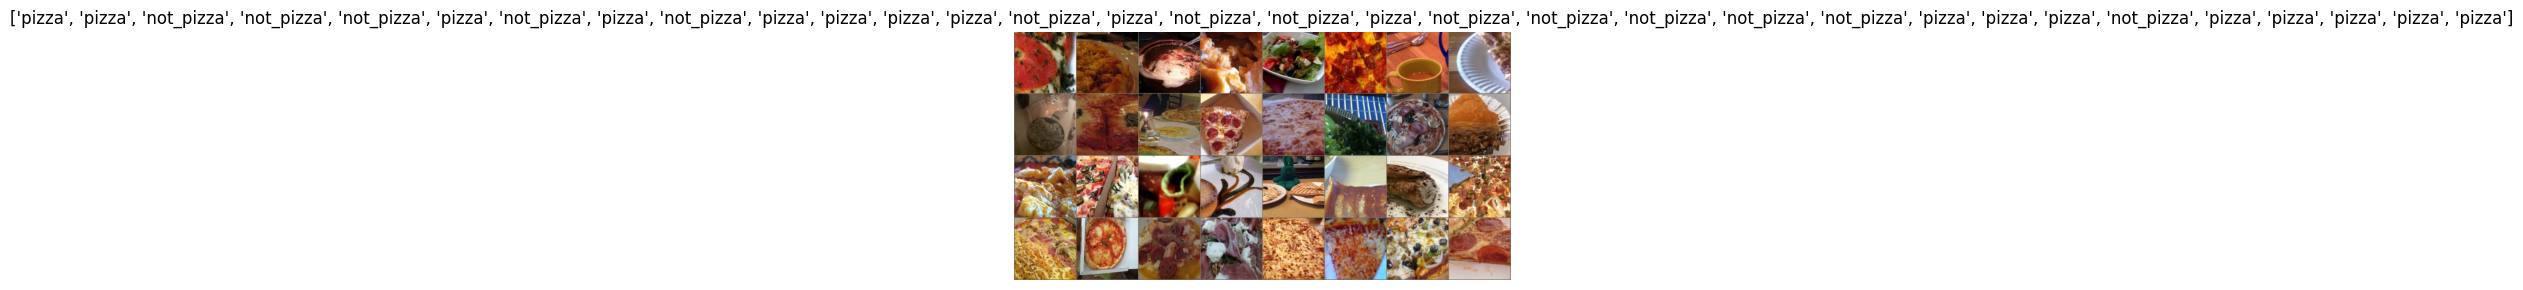

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to numpy and rearrange dimensions
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to valid range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Remove axes for better visualization
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))  # Use train_loader instead of dataloaders['train']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)  # Arrange images in a grid

# Display images
imshow(out, title=[class_names[x] for x in classes])


In [ ]:
import time
import os
import torch
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  # Use 'val' here for validation
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:  # Accessing 'train' or 'val' properly
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model



In [ ]:
import time
import os
import torch
import copy  # Importing copy module
from torch.optim import lr_scheduler

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=5):
    since = time.time()

    # Make sure to import 'copy' before using deepcopy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  # Use 'val' here for validation
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:  # Accessing 'train' or 'val' properly
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deepcopy best model weights only if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights to return the best performing model
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_model(model, dataloaders, device, class_names, num_images=6):
    """Visualizes model predictions for Pizza vs. Not Pizza classification."""
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(10, 6))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:  # Iterate over validation set
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot((num_images + 1) // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}')

                # Convert image to CPU and show
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return  # Stop when enough images are displayed


In [ ]:
def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
import copy  # Add this line
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


In [ ]:
# In cell 21
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(test_dataset)  # Change 'test' to 'val' to match the dataloaders dictionary
}

In [ ]:
dataloaders = {
    'train': train_loader,
    'val': test_loader  # Using 'val' key instead of 'test' for consistency
}

# Now call train_model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.2681 Acc: 0.8850
val Loss: 0.1804 Acc: 0.9235

Epoch 1/9
----------
train Loss: 0.2409 Acc: 0.9006
val Loss: 0.1808 Acc: 0.9290

Epoch 2/9
----------
train Loss: 0.2468 Acc: 0.9050
val Loss: 0.1775 Acc: 0.9235

Epoch 3/9
----------
train Loss: 0.2604 Acc: 0.8956
val Loss: 0.1787 Acc: 0.9235

Epoch 4/9
----------
train Loss: 0.2550 Acc: 0.8994
val Loss: 0.1791 Acc: 0.9235

Epoch 5/9
----------
train Loss: 0.2440 Acc: 0.9056
val Loss: 0.1790 Acc: 0.9262

Epoch 6/9
----------
train Loss: 0.2590 Acc: 0.8950
val Loss: 0.1779 Acc: 0.9262

Epoch 7/9
----------
train Loss: 0.2395 Acc: 0.9038
val Loss: 0.1807 Acc: 0.9235

Epoch 8/9
----------
train Loss: 0.2469 Acc: 0.9000
val Loss: 0.1750 Acc: 0.9317

Epoch 9/9
----------
train Loss: 0.2411 Acc: 0.9006
val Loss: 0.1751 Acc: 0.9317

Training complete in 1m 32s
Best val Acc: 0.931694


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Reorder from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])  # Mean for ImageNet normalization
    std = np.array([0.229, 0.224, 0.225])  # Standard deviation for ImageNet normalization
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be in range [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the plot

def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:  # Use the validation dataloader
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Make predictions with the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Loop through the batch and display images
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 3, images_so_far)  # Arrange the images in a 2x3 grid
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]} | Actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the model's training mode if it was training
                    return  # Exit after showing the required number of images

        model.train(mode=was_training)  # Restore training mode after all images are visualized


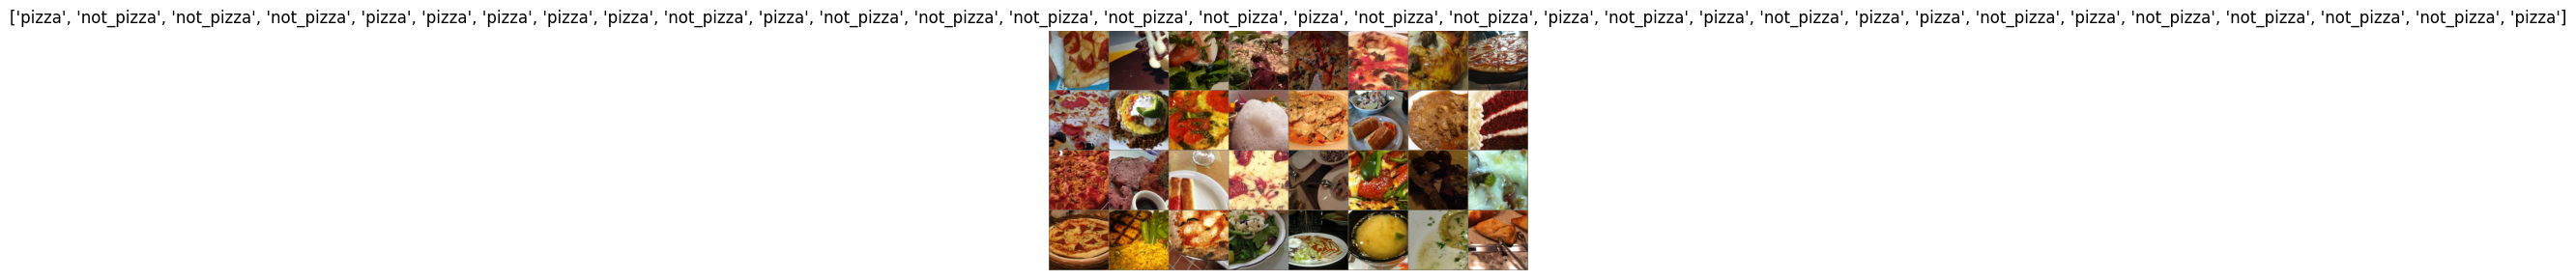

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

class ImageVisualizer:
    def __init__(self, train_loader, class_names):
        self.train_loader = train_loader
        self.class_names = class_names

    def imshow(self, inp, title=None):
        """Display image for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))  # Convert to numpy and rearrange dimensions
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean  # Unnormalize
        inp = np.clip(inp, 0, 1)  # Clip values to valid range
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.axis('off')  # Remove axes for better visualization
        plt.show()

    def visualize_batch(self):
        """Get a batch of training data and display images in a grid."""
        inputs, classes = next(iter(self.train_loader))  # Use train_loader

        # Make a grid from batch
        out = torchvision.utils.make_grid(inputs, nrow=8)  # Arrange images in a grid

        # Display images
        self.imshow(out, title=[self.class_names[x] for x in classes])

# Usage Example:
# Assuming you have 'train_loader' (your data loader) and 'class_names' (list of class names)

# Example usage
image_visualizer = ImageVisualizer(train_loader, class_names)
image_visualizer.visualize_batch()


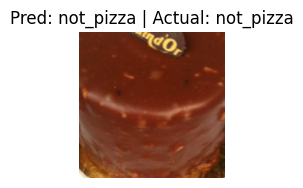

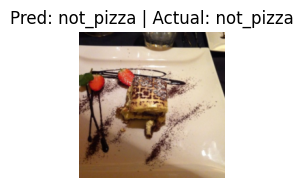

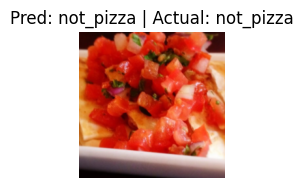

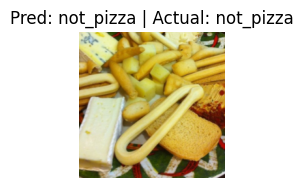

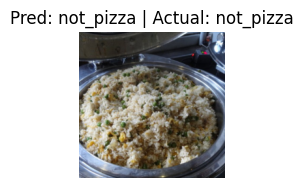

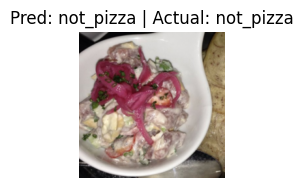

In [ ]:
# Assuming the following variables are defined:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replace 'train_loader' and 'test_loader' with your actual DataLoader objects
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

# Replace with actual class names
class_names = ['not_pizza', 'pizza']

# Visualize predictions on the validation set
visualize_model(model_ft, dataloaders, device, class_names, num_images=6)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Reorder from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])  # Mean for ImageNet normalization
    std = np.array([0.229, 0.224, 0.225])  # Standard deviation for ImageNet normalization
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be in range [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the plot

def visualize_model(model, dataloaders, device, class_names, num_images=6):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:  # Use the validation dataloader
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Make predictions with the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Loop through the batch and display images
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 3, images_so_far)  # Arrange the images in a 2x3 grid
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]} | Actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the model's training mode if it was training
                    return  # Exit after showing the required number of images

        model.train(mode=was_training)  # Restore training mode after all images are visualized


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

# Load pre-trained ResNet18 model
model_conv = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the final fully connected (FC) layer
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes (Pizza & Not Pizza)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Pizza and Not Pizza

# Move model to the appropriate device (GPU/CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

# Define loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Only optimize parameters of the final FC layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - decay LR by 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print("Model is ready for training!")


Model is ready for training!


In [ ]:
# Assuming you have dataloaders and dataset sizes defined as in the original train model code

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.5157 Acc: 0.7431
val Loss: 0.2900 Acc: 0.9208

Epoch 1/9
----------
train Loss: 0.3199 Acc: 0.8769
val Loss: 0.2192 Acc: 0.9262

Epoch 2/9
----------
train Loss: 0.3162 Acc: 0.8700
val Loss: 0.2516 Acc: 0.8989

Epoch 3/9
----------
train Loss: 0.2694 Acc: 0.8919
val Loss: 0.2053 Acc: 0.9290

Epoch 4/9
----------
train Loss: 0.2632 Acc: 0.8881
val Loss: 0.1921 Acc: 0.9126

Epoch 5/9
----------
train Loss: 0.2592 Acc: 0.8912
val Loss: 0.1816 Acc: 0.9208

Epoch 6/9
----------
train Loss: 0.2562 Acc: 0.8944
val Loss: 0.1791 Acc: 0.9262

Epoch 7/9
----------
train Loss: 0.2585 Acc: 0.8900
val Loss: 0.1837 Acc: 0.9344

Epoch 8/9
----------
train Loss: 0.2388 Acc: 0.9000
val Loss: 0.1799 Acc: 0.9262

Epoch 9/9
----------
train Loss: 0.2414 Acc: 0.9044
val Loss: 0.1762 Acc: 0.9262

Training complete in 1m 32s
Best val Acc: 0.934426


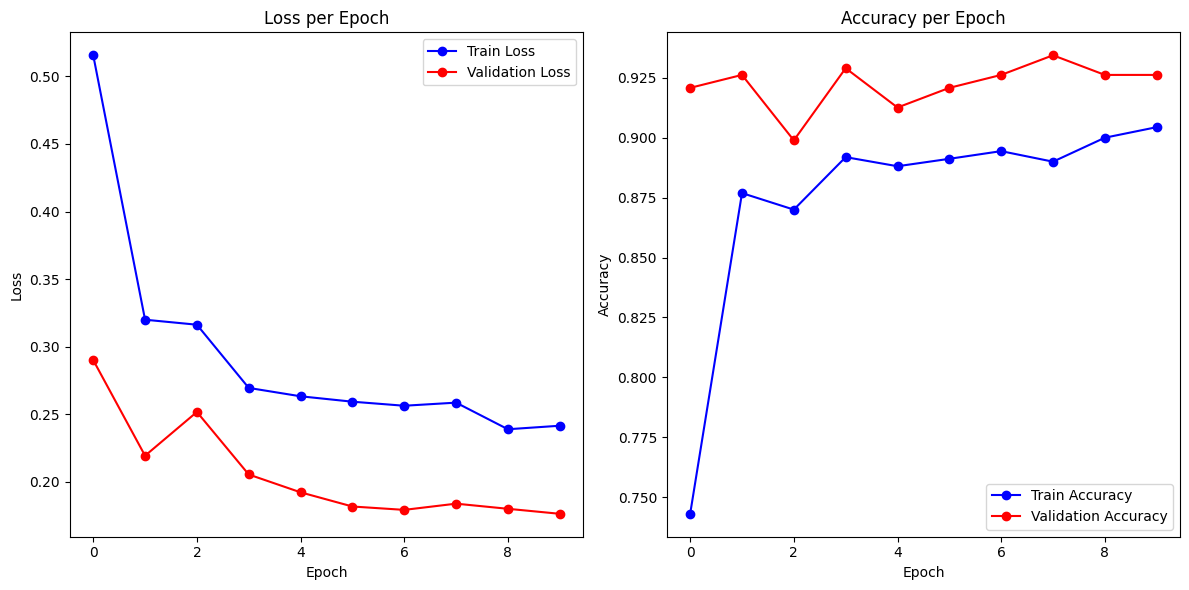

In [ ]:
import matplotlib.pyplot as plt

# Data from the training output
epochs = list(range(10))  # 10 epochs in total
train_loss = [0.5157, 0.3199, 0.3162, 0.2694, 0.2632, 0.2592, 0.2562, 0.2585, 0.2388, 0.2414]
train_acc = [0.7431, 0.8769, 0.8700, 0.8919, 0.8881, 0.8912, 0.8944, 0.8900, 0.9000, 0.9044]
val_loss = [0.2900, 0.2192, 0.2516, 0.2053, 0.1921, 0.1816, 0.1791, 0.1837, 0.1799, 0.1762]
val_acc = [0.9208, 0.9262, 0.8989, 0.9290, 0.9126, 0.9208, 0.9262, 0.9344, 0.9262, 0.9262]

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
ax1.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
ax1.set_title('Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
ax2.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o')
ax2.plot(epochs, val_acc, label='Validation Accuracy', color='red', marker='o')
ax2.set_title('Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


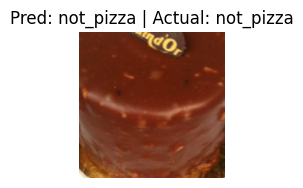

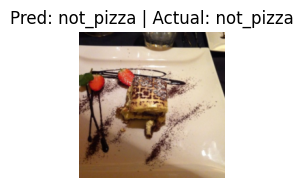

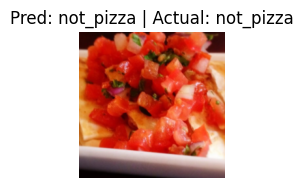

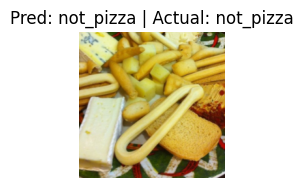

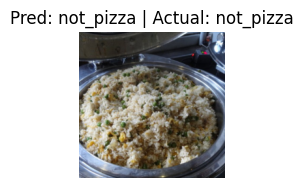

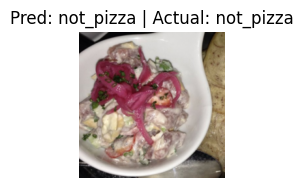

In [ ]:
visualize_model(model_conv, dataloaders, device, class_names, num_images=6)

plt.ioff()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def visualize_model_predictions(model, img_path, class_names, device):
    was_training = model.training
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    img = Image.open(img_path)
    img = data_transforms['test'](img)  # Use 'test' transform (resize, center crop, etc.)
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move image to the appropriate device (GPU/CPU)

    # Make predictions
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # Plot the image and the prediction
        fig, ax = plt.subplots(figsize=(6,6))
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

    model.train(mode=was_training)  # Restore the original training mode (if applicable)

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to numpy and rearrange dimensions
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to valid range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Remove axes for better visualization
    plt.show()


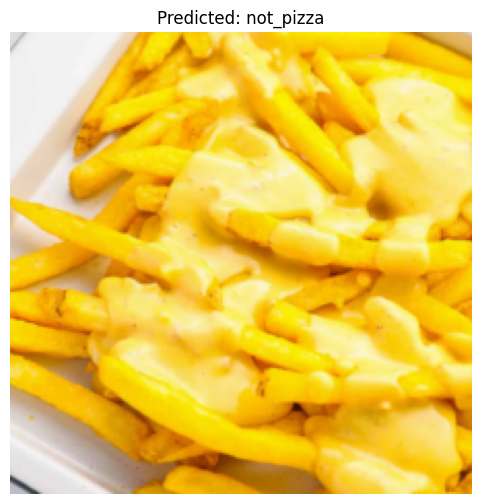

In [ ]:
img_path = '/content/featured-cheese-fries-recipe.jpg'  # Provide the path to your image
visualize_model_predictions(model_conv, img_path, class_names, device)


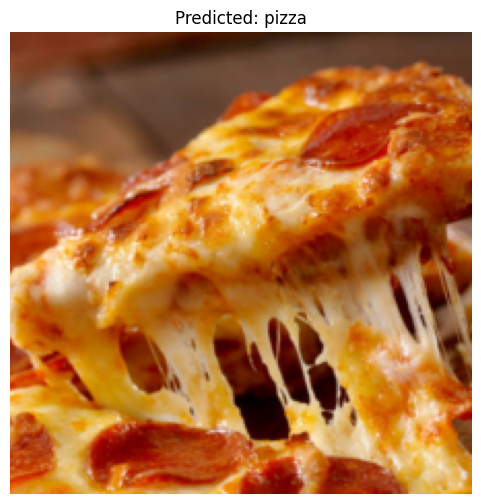

In [ ]:
img_path = '/content/istockphoto-938742222-612x612.jpg'  # Provide the path to your image
visualize_model_predictions(model_conv, img_path, class_names, device)


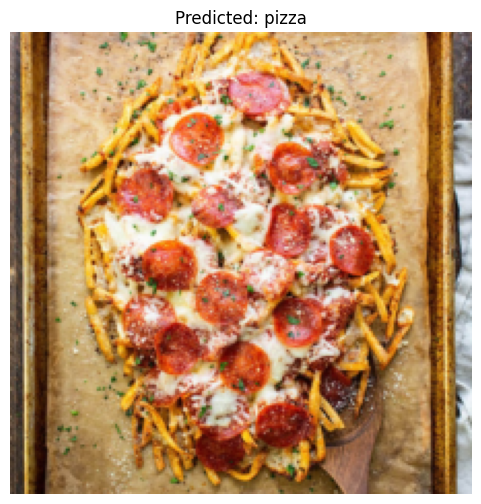

In [ ]:
img_path = '/content/Pizza-Fries-iowagirleats-02.jpg'  # Provide the path to your image
visualize_model_predictions(model_conv, img_path, class_names, device)


# Ant & Bee


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import kagglehub

In [ ]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download latest version
data_dir = kagglehub.dataset_download("ajayrana/hymenoptera-data")

# Extract the downloaded dataset if necessary
!unzip {data_dir}/hymenoptera_data.zip -d {data_dir}  # Assuming it's a zip file

# Update the data_dir to point to the extracted dataset directory
data_dir = os.path.join(data_dir, "hymenoptera_data")

print("Path to dataset files:", data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 90.2M/90.2M [00:00<00:00, 109MB/s]

Extracting files...


unzip:  cannot find or open /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1/hymenoptera_data.zip, /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1/hymenoptera_data.zip.zip or /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1/hymenoptera_data.zip.ZIP.
Path to dataset files: /root/.cache/kagglehub/datasets/ajayrana/hymenoptera-data/versions/1/hymenoptera_data


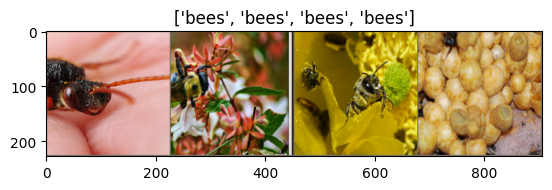

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5668 Acc: 0.7541
val Loss: 0.1883 Acc: 0.9412

Epoch 1/9
----------
train Loss: 0.4129 Acc: 0.8279
val Loss: 0.2588 Acc: 0.8889

Epoch 2/9
----------
train Loss: 0.3617 Acc: 0.8443
val Loss: 0.3748 Acc: 0.8693

Epoch 3/9
----------
train Loss: 0.5010 Acc: 0.7951
val Loss: 0.3050 Acc: 0.8954

Epoch 4/9
----------
train Loss: 0.5068 Acc: 0.8402
val Loss: 0.2444 Acc: 0.9085

Epoch 5/9
----------
train Loss: 0.3988 Acc: 0.8484
val Loss: 0.3655 Acc: 0.8562

Epoch 6/9
----------
train Loss: 0.5725 Acc: 0.7582
val Loss: 0.2349 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.4436 Acc: 0.8197
val Loss: 0.2684 Acc: 0.8824

Epoch 8/9
----------
train Loss: 0.3597 Acc: 0.8279
val Loss: 0.2920 Acc: 0.9085

Epoch 9/9
----------
train Loss: 0.2898 Acc: 0.8811
val Loss: 0.2657 Acc: 0.9085

Training complete in 0m 36s
Best val Acc: 0.941176


<ipython-input-72-f12f141f1f6d>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

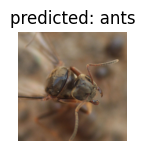

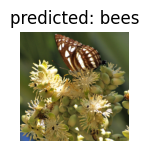

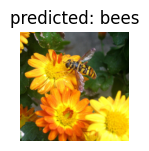

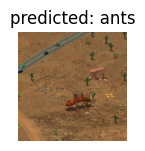

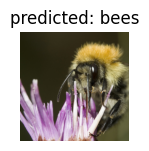

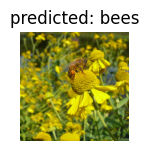

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4667 Acc: 0.7705
val Loss: 0.2882 Acc: 0.8693

Epoch 1/9
----------
train Loss: 0.6566 Acc: 0.7131
val Loss: 0.1772 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.4896 Acc: 0.8033
val Loss: 0.2126 Acc: 0.9216

Epoch 3/9
----------
train Loss: 0.3987 Acc: 0.8197
val Loss: 0.1904 Acc: 0.9346

Epoch 4/9
----------
train Loss: 0.4877 Acc: 0.8074
val Loss: 0.1993 Acc: 0.9281

Epoch 5/9
----------
train Loss: 0.5021 Acc: 0.7664
val Loss: 0.2340 Acc: 0.9281

Epoch 6/9
----------
train Loss: 0.3905 Acc: 0.8402
val Loss: 0.2087 Acc: 0.9281

Epoch 7/9
----------
train Loss: 0.3112 Acc: 0.8361
val Loss: 0.2044 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.4314 Acc: 0.8074
val Loss: 0.1850 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.3130 Acc: 0.8607
val Loss: 0.1948 Acc: 0.9281

Training complete in 0m 30s
Best val Acc: 0.947712


<ipython-input-72-f12f141f1f6d>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


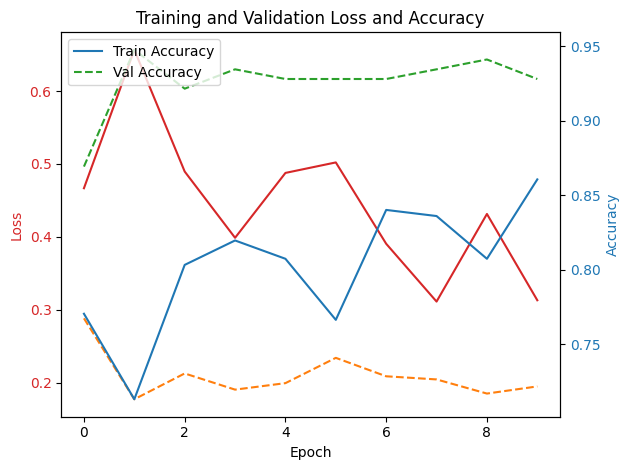

In [ ]:
import matplotlib.pyplot as plt

# Data from the training process
epochs = list(range(10))
train_loss = [0.4667, 0.6566, 0.4896, 0.3987, 0.4877, 0.5021, 0.3905, 0.3112, 0.4314, 0.3130]
train_acc = [0.7705, 0.7131, 0.8033, 0.8197, 0.8074, 0.7664, 0.8402, 0.8361, 0.8074, 0.8607]
val_loss = [0.2882, 0.1772, 0.2126, 0.1904, 0.1993, 0.2340, 0.2087, 0.2044, 0.1850, 0.1948]
val_acc = [0.8693, 0.9477, 0.9216, 0.9346, 0.9281, 0.9281, 0.9281, 0.9346, 0.9412, 0.9281]

# Plotting the graphs
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, train_loss, color='tab:red', label='Train Loss')
ax1.plot(epochs, val_loss, color='tab:orange', label='Val Loss', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(epochs, train_acc, color='tab:blue', label='Train Accuracy')
ax2.plot(epochs, val_acc, color='tab:green', label='Val Accuracy', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title
plt.title('Training and Validation Loss and Accuracy')

# Show the graph
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


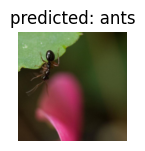

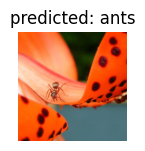

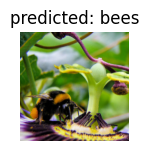

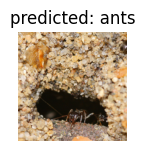

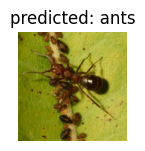

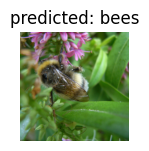

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


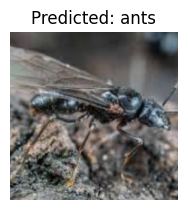

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/images.jpg'
)

plt.ioff()
plt.show()

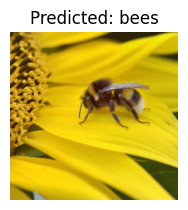

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/_20240827_bumblebee_heat_wave.jpg'
)

plt.ioff()
plt.show()

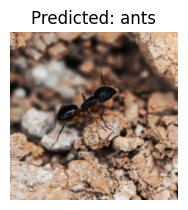

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/How-to-Find-An-Ant-Nest.webp'
)

plt.ioff()
plt.show()

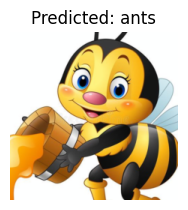

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='/content/11d0b7e37fefe98844656d284f1419cc.jpg'
)

plt.ioff()
plt.show()